In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

from collections.abc import Iterable 

In [3]:
from utils import plotting, transform, ingest
from forecast import stats, rf, run

In [4]:
cols = ["HOUST", "PERMIT"]
regions = ["NE", "MW", "S", "W"]

regional_hst = [f"HOUST{r}" for r in regions]
regional_permits = [f"PERMIT{r}" for r in regions]

In [5]:
raw_df = ingest.import_fred()

parsed_df = transform.standard(raw_df)

Using cached data at data/fred_data.csv


## Constants

In [6]:
lags = 48
end_train = "2019-01-01"

### Multivariate

In [7]:
houst_reg = parsed_df[regional_hst]

In [8]:
regional_data = houst_reg[regional_hst]

train = regional_data[:end_train]
test = regional_data[end_train:]

In [9]:
variables = regional_data.columns.tolist()

In [10]:
predictor = rf.make_forecaster(train, lags = lags, n_jobs = 4, verbose = 1)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  4.5min finished


In [11]:
df_forecast = run.iterative_forecast(predictor, train, lags, periods = 10)

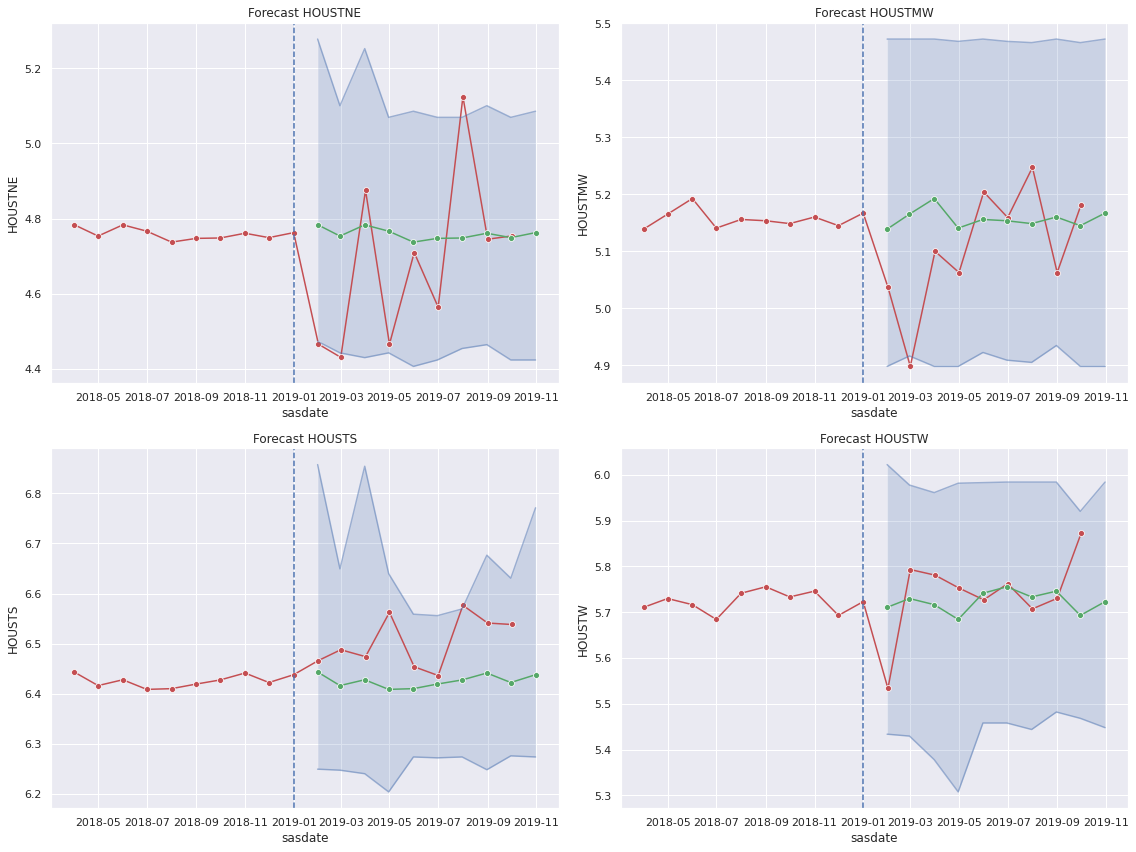

In [12]:
fig = plotting.plot_var(df_forecast, train, test, variables=regional_hst)

fig.show()

### Exogenous variables

In [13]:
regional_permits = [f"PERMIT{r}" for r in regions]
permits_reg = parsed_df[regional_permits]

In [14]:
init_year = "1960-01-01"

In [15]:
train = houst_reg[init_year:end_train]
exog = permits_reg[init_year:]

test = houst_reg[end_train:]

In [16]:
predictor = rf.make_forecaster(train, lags = lags, exog_df = exog, n_jobs = 4, verbose = 1)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  8.4min finished


In [17]:
df_forecast = run.iterative_forecast(predictor, train, lags, periods = 12, exog=exog)

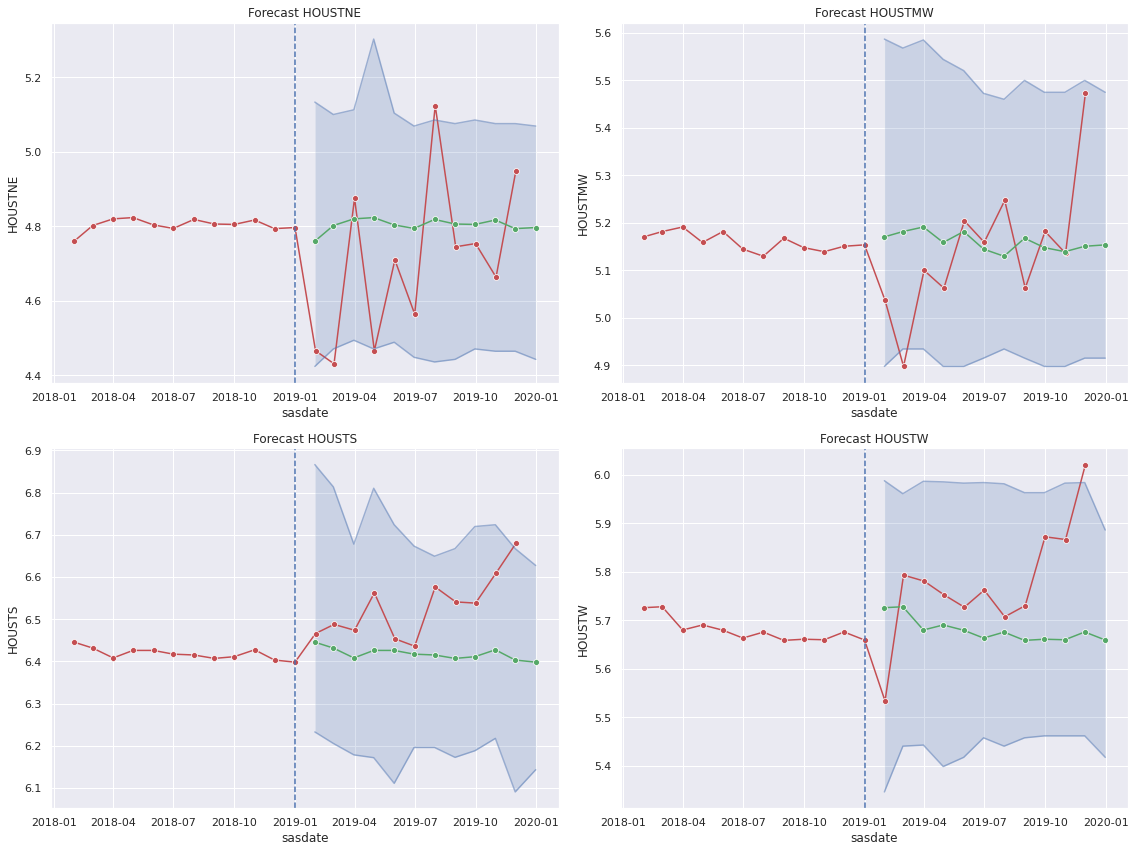

In [18]:
fig = plotting.plot_var(df_forecast, train, test, variables=regional_hst, pre_periods = 12)

fig.show()

In [19]:
%notify

<IPython.core.display.Javascript object>